# AutoInland Vehicle Insurance Claim Challenge StarterNotebook - Python

This is a simple starter notebook to get started with the AutoInland Vehicle Insurance Claim Challenge on Zindi.

This notebook covers:
- Loading the data
- Simple EDA and an example of feature enginnering
- Data preprocessing and data wrangling
- Creating a simple model
- Making a submission
- Some tips for improving your score

### Importing libraries

In [15]:
import pandas as pd
import numpy as np
import datetime as dt
from tqdm.notebook import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

### Read files

In [16]:
# Load files into a pandas dataframe
train = pd.read_csv('./data/Train.csv')
test = pd.read_csv('./data/Test.csv')
ss = pd.read_csv('./data/SampleSubmission.csv')

### Some basic EDA

In [17]:
# Preview the first five rows of the train set
train.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,NaN,NaN,Car Classic,0
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,NaN,NaN,Car Classic,1
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,NaN,NaN,Car Classic,0
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0
4,ID_00BRP63,2010-08-29,2010-12-31,Entity,20,2010-08-29,3,NaN,NaN,NaN,Lagos,Lagos,Muuve,1


In [18]:
# Preview the first five rows of the test set
test.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName
0,ID_01QM0NU,2010-10-23,2011-10-22,Female,46,2010-10-23,1,NaN,NaN,Ford,Abuja Municipal,Abuja-Municipal,Car Classic
1,ID_024NJLZ,2010-10-14,2011-10-13,Male,32,2010-10-14,1,NaN,NaN,NaN,Kosofe,Benue,Car Classic
2,ID_02NOVWQ,2010-08-29,2011-08-28,Female,45,2010-08-29,2,Saloon,Black,Honda,Wuse 11,Abuja,Car Classic
3,ID_02VSP68,2010-06-13,2011-06-12,Female,58,2010-06-13,1,Saloon,NaN,TOYOTA,NaN,NaN,CarSafe
4,ID_02YB37K,2010-07-01,2011-06-30,NaN,120,2010-07-01,1,Saloon,Red,Hyundai,Victoria Island,Lagos,Car Classic


In [ ]:
# Preview the first five rows of the sample submission file
ss.head()

In [ ]:
# Check the shape of the train and test sets
print(f'The shape of the train set is: {train.shape}\nThe shape of the test set is: {test.shape}')

In [ ]:
# Check if there any missing values in train set
ax = train.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

In [24]:
train[train['Age'] < 18]. count()

ID                        556
Policy Start Date         556
Policy End Date           556
Gender                    534
Age                       556
First Transaction Date    556
No_Pol                    556
Car_Category              356
Subject_Car_Colour        169
Subject_Car_Make          429
LGA_Name                  225
State                     225
ProductName               556
target                    556
dtype: int64

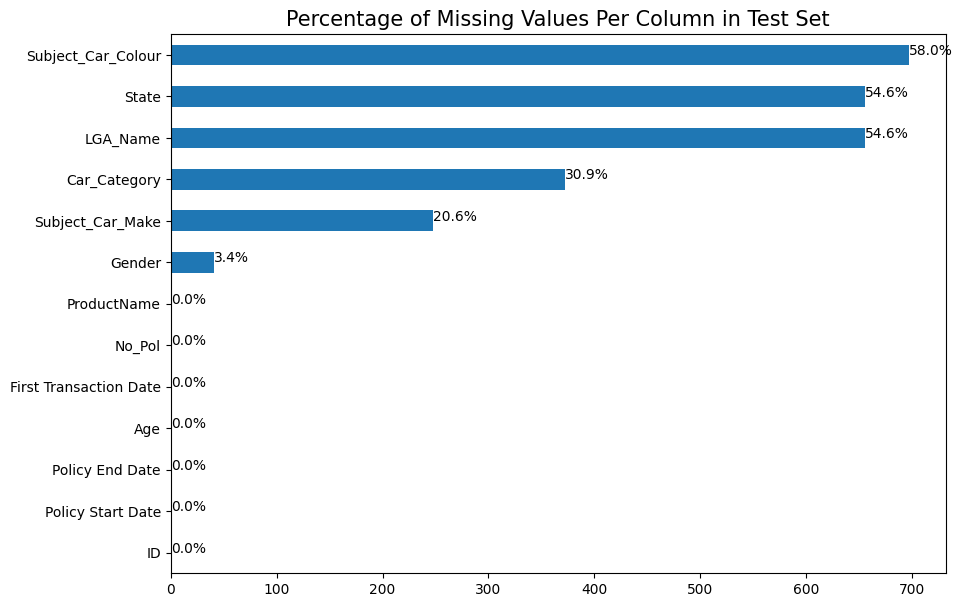

In [19]:
# Check if there missing values in test set
ax = test.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7))
plt.title('Percentage of Missing Values Per Column in Test Set', fontdict={'size':15})

for p in ax.patches:
    percentage ='{:,.1f}%'.format((p.get_width()/test.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

## Combine train and test set for easy preprocessing 

In [ ]:
# Combine train and test set
ntrain = train.shape[0] # to be used to split train and test set from the combined dataframe

all_data = pd.concat((train, test)).reset_index(drop=True)
print(f'The shape of the combined dataframe is: {all_data.shape}')

In [ ]:
# Preview the last five rows of the combined dataframe
all_data.tail()

In [ ]:
# Check the column names and datatypes
all_data.info()

In [ ]:
# Change each column to its appriopriate datatype
date_cols = [col for col in all_data.columns if 'Date' in col]
num_cols = ['Age', 'No_Pol']
cat_cols = [col for col in all_data.columns if col not in date_cols+num_cols+['ID', 'target']]

for col in all_data.columns:
  if col in date_cols:
    all_data[col] = pd.to_datetime(all_data[col])
  elif col in cat_cols:
    all_data[col] = all_data[col].astype('category')

# Confirm whether the changes have been applied successfully
all_data.info()

### Distribution of the target variable

In [ ]:
sns.countplot(train.target)
plt.title('Target Distribution', fontdict={'size':14});

### Distribution of the Gender column

In [ ]:
# Gender distribution 
ax = all_data.Gender.value_counts().sort_values().plot(kind = 'barh', figsize=(10,7))
plt.title('Gender Distribution', fontdict={'size': 15})
for p in ax.patches:
  percentage ='{:,.1f}%'.format((p.get_width()/all_data.shape[0])*100)
  width, height =p.get_width(),p.get_height()
  x=p.get_x()+width+0.02
  y=p.get_y()+height/2
  ax.annotate(percentage,(x,y))

In [ ]:
mapper = {'Entity':'Other', 'Joint Gender':'Other', 'NOT STATED':'Other', 'NO GENDER': 'Other', 'SEX':"Other"}
all_data.Gender = all_data.Gender.replace(mapper)

# Confirm mappings
all_data.Gender.value_counts()

### Number of unique values per categorical column

In [ ]:
# Check unique values for each categorical column
for col in cat_cols:
  print(col)
  print(all_data[col].unique(), '\n')

### Filling in missing values
#### Missing values can be filled using different strategies
Tips:
 - Mean
 - Max
 - Min
 - [sklearn SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)
 - Others... do more reasearch

In [ ]:
# Fill in missing values
# For cat cols and date cols fill in with mode and for num cols fill in with 9999
for col in all_data.columns:
  if col in date_cols+cat_cols:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])
  elif col in num_cols:
    all_data[col] = all_data[col].fillna(all_data[col].fillna(9999))

# Confirm that there aren't any missing values
all_data[all_data.columns.difference(['target'])].isna().sum()

### Feature Engineering
#### Alot of features can be extracted from dates
Tips:
 - Quarter, Start of Year, month?
 - Is it a weekend, weekday?
 - Is it a holiday
 - Duration between different periods, e.g start and end of a policy
 - What features can be derived from the age column
 - Be creative 😉

In [ ]:
# Extract date features from the date columns
for col in date_cols:
  for date_feature in ['year', 'month', 'day']:
    all_data[col+date_feature] = getattr(all_data[col].dt, date_feature)

all_data.head()

#### Try different strategies of dealing with categorical variables
Tips:
 - One hot encoding
 - Label encoding
 - Target encoding
 - Reduce the number of unique values...

In [ ]:
# Encode categorical features
all_data = pd.get_dummies(data = all_data, columns = cat_cols)
all_data.head()

In [ ]:
# Separate train and test data from the combined dataframe
train_df = all_data[:ntrain]
test_df = all_data[ntrain:]

# Check the shapes of the split dataset
train_df.shape, test_df.shape

### Training and making predictions
Tips:
- Is lgbm the best model for this challenge?
- Parameter tuning
 - Grid search, random search, perhaps bayesian search works better...



In [ ]:
# Select main columns to be used in training
main_cols = all_data.columns.difference(date_cols+['ID', 'target'])
X = train_df[main_cols]
y = train_df.target

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

# Train model
model = LGBMClassifier()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Check the f1 score of the model
print(f'F1 score on the X_test is: {f1_score(y_test, y_pred)}')

#### [More on F1 Score](https://en.wikipedia.org/wiki/F-score)

### Making predictions of the test set and creating a submission file

In [ ]:
# Make prediction on the test set
test_df = test_df[main_cols]
predictions = model.predict(test_df)

# Create a submission file
sub_file = ss.copy()
sub_file.predictions = predictions

# Check the distribution of your predictions
sns.countplot(sub_file.predictions);

In [ ]:
# Create a csv file and upload to zindi 
sub_file.to_csv('Baseline.csv', index = False)

###More Tips
- Thorough EDA and domain knowledge sourcing
- Re-group Categorical features 
- More Feature Engineering 
- Dataset balancing - oversampling, undersampling, SMOTE...
- Ensembling of models 
- Cross-validation: Group folds, Stratified...

# ******************* GOOD LUCK!!! ***************************

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# For data preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# For modeling
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Models
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

ModuleNotFoundError: No module named 'catboost'

In [ ]:

# Load data
print("Loading data...")
train = pd.read_csv('./data/Train.csv')
test = pd.read_csv('./data/Test.csv')
sample_submission = pd.read_csv('./data/SampleSubmission.csv')

# Display info
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

# Combine datasets for preprocessing
train['is_train'] = 1
test['is_train'] = 0
test['target'] = -1  # Placeholder for test set
combined = pd.concat([train, test], axis=0, ignore_index=True)

# Check missing values
print("\nMissing values before imputation:")
print(combined.isnull().sum().sort_values(ascending=False))

# Feature Engineering
print("\nPerforming feature engineering...")

# Convert date columns to datetime
date_cols = [col for col in combined.columns if 'Date' in col]
for col in date_cols:
    combined[col] = pd.to_datetime(combined[col], errors='coerce')

# Extract date features
for col in date_cols:
    # Basic date components
    combined[f'{col}_year'] = combined[col].dt.year
    combined[f'{col}_month'] = combined[col].dt.month
    combined[f'{col}_day'] = combined[col].dt.day
    combined[f'{col}_dayofweek'] = combined[col].dt.dayofweek
    combined[f'{col}_quarter'] = combined[col].dt.quarter
    
    # Is weekend
    combined[f'{col}_is_weekend'] = combined[col].dt.dayofweek.isin([5, 6]).astype(int)

# Calculate policy duration in days
combined['policy_duration'] = (combined['Policy End Date'] - combined['Policy Start Date']).dt.days

# Calculate days since first transaction
combined['days_since_first_transaction'] = (combined['Policy Start Date'] - combined['First Transaction Date']).dt.days

# Age groups
combined['age_group'] = pd.cut(combined['Age'], 
                               bins=[0, 25, 35, 45, 55, 65, 100], 
                               labels=['<25', '25-35', '35-45', '45-55', '55-65', '65+'])

# Clean and transform categorical features
print("\nHandling categorical features...")

# Gender cleaning
gender_mapping = {
    'Entity': 'Other', 
    'Joint Gender': 'Other', 
    'NOT STATED': 'Unknown', 
    'NO GENDER': 'Unknown', 
    'SEX': 'Unknown'
}
combined['Gender'] = combined['Gender'].replace(gender_mapping)

# No_Pol groups
combined['No_Pol_group'] = pd.cut(combined['No_Pol'], 
                                 bins=[0, 1, 3, 5, 10, float('inf')], 
                                 labels=['Single', '2-3', '4-5', '6-10', '10+'])

# Identify categorical columns
cat_cols = combined.select_dtypes(include=['object', 'category']).columns.tolist()
cat_cols.append('age_group')
cat_cols.append('No_Pol_group')
cat_cols = [x for x in cat_cols if x not in ['ID', 'target'] + date_cols]

# Identify numerical columns  
num_cols = ['Age', 'No_Pol', 'policy_duration', 'days_since_first_transaction']
num_cols.extend([col for col in combined.columns if ('_year' in col or '_month' in col or 
                                                   '_day' in col or '_dayofweek' in col or 
                                                   '_quarter' in col or '_is_weekend' in col)])

# Handle missing values
print("\nHandling missing values...")
# For numerical columns use median
for col in num_cols:
    if combined[col].isnull().any():
        combined[col] = combined[col].fillna(combined[col].median())

# For categorical columns use mode
for col in cat_cols:
    if combined[col].isnull().any():
        combined[col] = combined[col].fillna(combined[col].mode()[0])

# Check for high cardinality categories
print("\nCategorical feature cardinality:")
for col in cat_cols:
    print(f"{col}: {combined[col].nunique()} unique values")

# Frequency encode high-cardinality categorical features
high_card_cols = [col for col in cat_cols if combined[col].nunique() > 10]
for col in high_card_cols:
    freq_map = combined[col].value_counts(normalize=True).to_dict()
    combined[f'{col}_freq'] = combined[col].map(freq_map)
    num_cols.append(f'{col}_freq')

# Split back into train and test
train_processed = combined[combined['is_train'] == 1].drop('is_train', axis=1)
test_processed = combined[combined['is_train'] == 0].drop(['is_train', 'target'], axis=1)

# Drop date columns which we've extracted features from
train_processed = train_processed.drop(date_cols, axis=1)
test_processed = test_processed.drop(date_cols, axis=1)

# Define features and target
X = train_processed.drop(['ID', 'target'], axis=1)
y = train_processed['target']
X_test = test_processed.drop(['ID'], axis=1)

# Get updated cat_cols (excluding any we've dropped)
cat_cols = [col for col in cat_cols if col in X.columns]
num_cols = [col for col in num_cols if col in X.columns]

print(f"\nFeatures: {X.shape[1]} columns")
print(f"Categorical: {len(cat_cols)} columns")
print(f"Numerical: {len(num_cols)} columns")

# Check target distribution
print("\nTarget distribution:")
print(y.value_counts(normalize=True))

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_cols),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), cat_cols)
    ],
    remainder='passthrough'
)

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define models
print("\nTraining models...")

# Create a stratified k-fold object
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Train LightGBM model with SMOTE
print("Training LightGBM model...")
lgbm_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LGBMClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=7,
        num_leaves=31,
        min_child_samples=20,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=0.1,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ))
])

# Fit the pipeline
lgbm_pipeline.fit(X_train, y_train)

# Make predictions on validation set
y_val_pred_lgbm = lgbm_pipeline.predict(X_val)

# Evaluate model
val_f1_lgbm = f1_score(y_val, y_val_pred_lgbm)
print(f"LightGBM Validation F1 Score: {val_f1_lgbm:.4f}")
print(classification_report(y_val, y_val_pred_lgbm))

# Train XGBoost model
print("\nTraining XGBoost model...")
xgb_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=1,
        random_state=42,
        n_jobs=-1
    ))
])

# Fit the pipeline
xgb_pipeline.fit(X_train, y_train)

# Make predictions on validation set
y_val_pred_xgb = xgb_pipeline.predict(X_val)

# Evaluate model
val_f1_xgb = f1_score(y_val, y_val_pred_xgb)
print(f"XGBoost Validation F1 Score: {val_f1_xgb:.4f}")
print(classification_report(y_val, y_val_pred_xgb))

# Create an ensemble model
print("\nCreating ensemble model...")
ensemble = VotingClassifier(estimators=[
    ('lgbm', lgbm_pipeline.named_steps['classifier']),
    ('xgb', xgb_pipeline.named_steps['classifier'])
], voting='soft')

# We need to preprocess and apply SMOTE before ensemble
X_train_prep = preprocessor.fit_transform(X_train)
X_val_prep = preprocessor.transform(X_val)
X_test_prep = preprocessor.transform(X_test)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_prep, y_train)

# Train ensemble
ensemble.fit(X_train_smote, y_train_smote)

# Make predictions
y_val_pred_ensemble = ensemble.predict(X_val_prep)
val_f1_ensemble = f1_score(y_val, y_val_pred_ensemble)
print(f"Ensemble Validation F1 Score: {val_f1_ensemble:.4f}")
print(classification_report(y_val, y_val_pred_ensemble))

# Choose the best model
best_model_name = max([('lgbm', val_f1_lgbm), ('xgb', val_f1_xgb), ('ensemble', val_f1_ensemble)], key=lambda x: x[1])[0]
print(f"\nBest model: {best_model_name}")

# Make predictions on test set with the best model
if best_model_name == 'lgbm':
    test_preds = lgbm_pipeline.predict(X_test)
elif best_model_name == 'xgb':
    test_preds = xgb_pipeline.predict(X_test)
else:
    test_preds = ensemble.predict(X_test_prep)

# Create submission file
submission = pd.DataFrame({
    'ID': test_processed['ID'],
    'target': test_preds
})

# Save the submission file
submission.to_csv('improved_submission.csv', index=False)
print("\nSubmission file created: improved_submission.csv")

# Feature importance for LGBM (if it's the best model)
if best_model_name == 'lgbm':
    print("\nTop 20 features by importance (LGBM):")
    lgbm_model = lgbm_pipeline.named_steps['classifier']
    feature_names = num_cols + cat_cols  # This is simplified, actual feature names after preprocessing would be different
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': lgbm_model.feature_importances_
    })
    feature_importance = feature_importance.sort_values('importance', ascending=False).head(20)
    print(feature_importance)

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
import sys
print(sys.executable)


In [ ]:
python -m ipykernel install --user --name=venv --display-name "Python (venv)"


In [ ]:
import sys
print(sys.path)
